# 使用Sequence to Sequence网络和注意力机制进行翻译

本教程我们将会搭建一个网络来将法语翻译成英语。
```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

这可以通过 [Sequence to sequence network](https://arxiv.org/abs/1409.3215) 简单而又强大的 idea来实现，该实现包含两个循环神经网络，它们共同工作从而将一个序列转化为另一个序列：编码器网络将输入压缩成矢量；解码器网络将该矢量展开成新的序列。  

![](https://pytorch.org/tutorials/_images/seq2seq.png)
<center><strong>图1. Sequence to sequence 网络结构</strong>

为了增强模型的表现力，我们同时引入了注意力机制，它使得解码器能够学习到在翻译某个部分的时候该给整个序列多少的注意力。

**依赖包**

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1. 加载数据文件

本教程的数据文件是几千个英语到法语的翻译句子对。

>翻译开源下载地址:[http://www.manythings.org/anki/](http://www.manythings.org/anki/)

点击[这里](https://download.pytorch.org/tutorial/data.zip)下载本教程所需的翻译文件。

解压到当前目录下，得到一个 `data/eng-fra.txt`文件，该文件每一行是由 tab 分隔开的翻译对:
```
I am cold.   J'ai froid.
```


类似于字符级RNN编码字母序列，我们仍然将源语言的每个单词编码为一个one-hot向量。与语言中可能存在的几十个字符相比，词语的量显然更大，因此编码向量要大得多。我们在这里做个小小的弊，修剪数据----每种语言我们只采用几千个单词。

![](https://pytorch.org/tutorials/_images/word-encoding.png)
<center><strong>图2. one-hot 编码示例</strong>

为了编码词语，我们需要每个单词的唯一索引，以便后续网络的输入和目标的构建。为此我们使用一个名为 `Lang` 的辅助类，它具有 word$\rightarrow$index (word2index) 和 index$\rightarrow$word(index2word)两个字典，以及用于稍后替换稀有单词的每个单词的计数(word2count)

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1:"EOS"}
        self.n_words = 2 # Count SOS and EOS
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word]=self.n_words
            self.word2count[word]=1
            self.index2word[self.n_words]=word
            self.n_words +=1
        else:
            self.word2count[word]+=1

文件都是Unicode编码的，我们需要简单得将字符转化为ASCII编码，全部转化为小写字母，并修剪大部分标点符号。

In [4]:
# Turn a Unicode string to plain ASCII, thanks to 
# http://stackoverflow.com/a/518232/2809427
def unicode2Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicode2Ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

读取数据，我们将文件分割成行，进一步分割成句子对。文件是 English$\rightarrow$其他语言 ，所以这里加上一个 `reverse` 参数，可以用来获取 其他语言$\rightarrow$英语 的翻译对。  

In [5]:
def readLangs(lang1, lang2, reverse = False):
    print("Reading lines...")
    
    # Read the file and split into lines
    lines = open('data/%s-%s.txt'%(lang1,lang2), encoding='utf-8').\
        read().strip().split('\n')
        
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

由于样本句子很多，而我们想加速训练。我们会将数据集修剪成相对简短的句子。这里的最大长度是10(包括结束标点)，同时我们会过滤出 "我是","他是" 这种形式的句子(别忘记之前忽略的撇号,比如 "I'm" 这种形式)。

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)

def filterPair(p):
    return len(p[0].split(' '))< MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

完整的数据准备流程如下：
- 读取文本文件，按行分割，再将每行分割成语句对
- 归一化文本，过滤内容和长度
- 根据滤出的句子对创建词语列表

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng','fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11893 sentence pairs
Counting words...
Counted words:
fra 4920
eng 3228
['tu es merveilleux .', 'you re wonderful .']


## 2. Seq2Seq 模型

循环神经网络对一个序列操作，然后将其输出作为下一个子操作的输入。

一个 Sequence to Sequence，或者叫 seq2seq 网络，又或者叫 编码-解码网络，包含了两个RNN部分：编码器和解码器。编码器网络将输入序列转化为单个向量，解码器读取这个向量，将其转化为序列输出。**图1** 展示了这个结构。这里我们回顾下图1：

![](https://pytorch.org/tutorials/_images/seq2seq.png)
<center><strong>图1. Sequence to sequence 网络结构</strong>

与使用单个RNN的序列预测不同(单个RNN序列预测的每个输入都对应一个输出), seq2seq模型使得我们能从序列的长度和顺序中解放出来，这使得其能够成为两种语言之间相互转换的理想选择。 

考虑一个句子对:
```
Je ne suis pas le char noir     I am not the black cat
```
输入句子中很多单词可以直接翻译到对应的输出句子中，但是可能会有细微的顺序变动，比如 `chat noir` 和 `black cat`。此外由于`ne/pas`结构，输入句子比输出句子多一个单词。直接通过翻译输入词语的产生正确的翻译句子是很困难的。


使用seq2seq模型，编码器创建单个向量，在理想情况下，将输入序列的“语义”编码为单个向量---代表句子的某些N维空间中的单个点

### 2.1 编码器

seq2seq网络的编码器是一个RNN，它通过**阅读**输入句子的每个单词，来生成一些值。对每一个输入单词，编码器输出一个向量和一个隐藏状态，并且使用这个隐藏状态作为下一个单词的输入。
![](https://pytorch.org/tutorials/_images/encoder-network.png)
<center><strong>图3. 编码器结构</strong>

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self,input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1, self.hidden_size, device=device)

### 2.2 解码器

解码器使用编码器输出的向量作为输入，输出一串单词，从而完成翻译。

#### 简单的解码器
在最简单的解码器中我们仅仅使用编码器最后一步的输出作为输入。这个最后一步的输出有时候被称为**(上下文向量)context vector** 因为它编码了整个文本序列。这个上下文向量被用作解码器的初始隐藏状态。

在解码的每一步，解码器接受一个词语和一个隐藏状态。初始的输入词语是单词开始标记`<SOS>`，初始隐藏状态是上文提到的上下文向量。
![](https://pytorch.org/tutorials/_images/decoder-network.png)
<center><strong>图4. 简单的解码器结构</strong>

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,input, hidden):
        output = self.embedding(input).view(1,1,-1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1, self.hidden_size, device=device)
    

我鼓励你训练和观察这个模型的结果，但为了节省空间，我们将"直捣黄龙"并引入注意机制。

#### 注意力的解码器

如果仅仅是在编码器和解码器之间传递上下文向量， 对单个向量来说，表达整个句子是很困难的。

注意力机制允许解码器在解码的每一步获得一个关于原始句子的注意量(即是说，这一步的翻译需要在原始句子的不同部分投入多少的注意力)。首先我们计算一个注意力权重的集合。这些权重将和编码器的输出向量相乘来获得一个权重敏感的输出。这个步骤的结果(在代码里为`attn_applied`)应包含有关输入序列特定部分的信息，从而帮助解码器选择正确的输出字。

![](https://i.imgur.com/1152PYf.png)
<center><strong>图5. 注意力结构</strong>

使用一个前馈层 `attn` 来计算注意力权重，它使用解码器的输入和隐藏状态作为输入。因为训练数据中的句子长短不一，因此要创建和训练这一层，就必须选择最长的句子长度。最大长度的句子将使用所有注意力量，而较短的句子将仅使用前几个。

![](https://pytorch.org/tutorials/_images/attention-decoder-network.png)
<center><strong>图6. 注意力解码器结构</strong>

In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size, dropout_p=0.1, max_length = MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat([embedded[0],hidden[0]],1)),dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        
        output = torch.cat([embedded[0], attn_applied[0]],1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]),dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1,1, self.hidden_size, device=device)
    

通过使用相对位置方法，还有其他形式的注意力可以解决长度限制问题。参考 [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)

## 3. 训练

### 3.1 准备训练数据

对每个训练样本对，我们需要一个输入张量(输入句子中每个词语在词典中的位置)和目标张量(目标句子中每个词语在词典中的的位置)。在创建这些向量的同时，我们给两个都句子都加上 EOS 作为结束词

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 3.2 训练模型

我们将句子输入到编码器网络中，同时跟踪其每一步的输出和最后一步的隐藏状态。然后解码器网络接受一个 `<SOS>` 作为第一步的输入，编码器最后一步的隐藏状态作为其初始隐藏状态。

这里有个选择问题：关于解码器的每一步，我们到底使用目标字母直接输入，还是使用前一步的网络预测结果作为输入？

**Teacher forcing** 概念：使用真实目标输出作为下一个输入，而不是使用解码器的预测作为下一个输入。使用**teacher forcing**可以使网络更快地收敛，但是当受过训练的网络被运用时，它可能表现出不稳定性。

你可以观察下网络的输出，读起来看似语法相关，但是实际上远离正确的翻译---直觉上网络学到了如何表示输出语法，并且一旦'Teacher'告诉它前面几个单词，它就会“提取”含义，但它还没有正确地学习如何从翻译中创建句子。  

由于PyTorch的autograd为我们提供了自由度，我们可以随意选择使用teacher forcing或不使用通过简单的if语句。将teacher_forcing_ratio来控制使用的概率

In [12]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei]=encoder_output[0,0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the targer as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss+=criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]   # Teacher forcing
            
    else:
        # Without teaching forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() # detach from history as input
            
            loss+=criterion(decoder_output, target_tensor[di])
            if decoder_input.item()==EOS_token:
                break
                
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

下面是一个辅助函数，用于打印经过的时间和估计的剩余时间，通过给定的当前时间和进度％。

In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

完整的训练流程如下：
- 计时器打开
- 初始化优化器和评估函数
- 创建训练对
- 开始跟踪损失

然后我们会多次调用 `train` ，间断打印进度（例子的百分比，到目前为止的时间，估计的时间）和平均损失。

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=1000, learning_rate=0.01):
    start = time.time()
    plot_losses=[]
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0   # Reset every plot_every
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total+=loss
        plot_loss_total+=loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 3.3 可视化结果

In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## 4. 评估

评估与训练大致相同，但没有目标，因此我们只需将解码器的预测反馈给每个步骤。每次它预测一个单词时我们都会将它添加到输出字符串中，如果它预测了EOS标记，我们就会停止。我们还存储解码器的注意力输出以供稍后显示。

In [16]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

 我们可以从训练集中评估随机句子并打印输入，目标和输出以做出一些主观质量判断：


In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 5. 训练与评估

有了所有这些辅助函数（它看起来像是额外的工作，但它使得更容易运行多个实验）我们实际上可以初始化网络并开始训练。 

请记住，输入句子被严重过滤。对于这个小数据集，我们可以使用256个隐藏节点和单个GRU层的相对较小的网络。在MacBook CPU上大约40分钟后，我们将得到一些合理的结果。

In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

3m 53s (- 54m 26s) (5000 6%) 3.0454
7m 35s (- 49m 23s) (10000 13%) 2.4611
11m 4s (- 44m 16s) (15000 20%) 2.1786
14m 31s (- 39m 55s) (20000 26%) 1.8817
17m 59s (- 35m 59s) (25000 33%) 1.7361
21m 27s (- 32m 10s) (30000 40%) 1.5839
24m 53s (- 28m 26s) (35000 46%) 1.4429
28m 18s (- 24m 46s) (40000 53%) 1.2940
31m 45s (- 21m 10s) (45000 60%) 1.1935
35m 19s (- 17m 39s) (50000 66%) 1.1049
38m 52s (- 14m 8s) (55000 73%) 1.0309
42m 23s (- 10m 35s) (60000 80%) 0.9482
45m 54s (- 7m 3s) (65000 86%) 0.8536
49m 29s (- 3m 32s) (70000 93%) 0.8255
53m 15s (- 0m 0s) (75000 100%) 0.7671


In [19]:
evaluateRandomly(encoder1,  attn_decoder1)

> j y travaille encore .
= i m still working on it .
< i m still working on it . <EOS>

> je suis fatigue de toutes ces reflexions .
= i m tired of all this nagging .
< i am tired of all this room . <EOS>

> vous etes timide n est ce pas ?
= you re shy aren t you ?
< you re shy aren t you ? <EOS>

> je suis pret pour mon prochain defi .
= i m ready for my next challenge .
< i m ready for my own days . <EOS>

> il est tres fier de sa moto trafiquee .
= he s very proud of his custom motorcycle .
< he is very proud of his parents of success .

> vous etes responsable .
= you are to blame .
< you are early . <EOS>

> vous avez tout a fait raison .
= you re absolutely right .
< you are always right . <EOS>

> tu es l ainee .
= you re the oldest .
< you re the oldest . <EOS>

> tu veux juste paraitre diplomate .
= you re just being diplomatic .
< you re just being . . <EOS>

> vous n etes pas le bienvenu ici .
= you re not welcome here .
< you re not welcome here . <EOS>



### 4.1 可视化注意力

注意机制的一个很有用的特性是其高度可解释的输出。因为它用于对输入序列的特定编码器输出进行加权，所以我们可以想象在每个时间步长看网络最关注的位置。

你可以简单地运行`plt.matshow(attentions)` 以将注意力输出显示为矩阵，其中列是输入步骤，行是输出步骤：

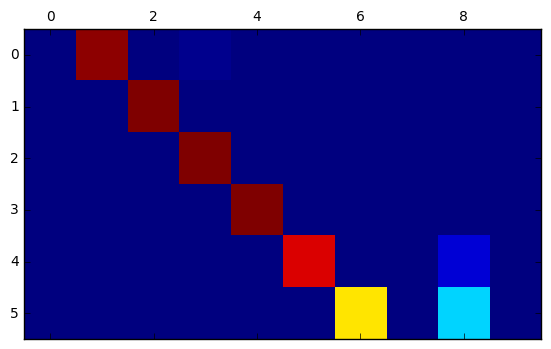

In [20]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

为了更好地展示结果，我们给轴添加上标签：

input =  elle a cinq ans de moins que moi .
output =  she s five years younger than me . <EOS>


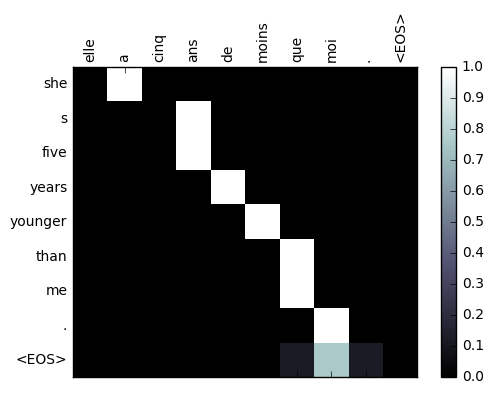

input =  elle est trop petit .
output =  she is too short . <EOS>


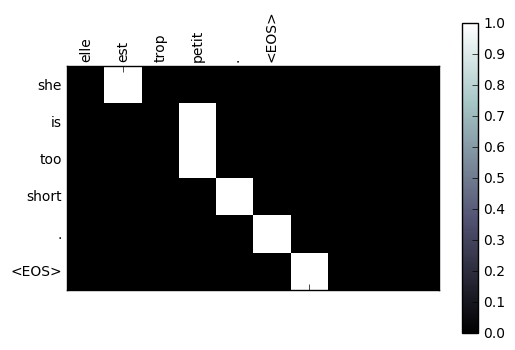

input =  je ne crains pas de mourir .
output =  i m not dying to die . <EOS>


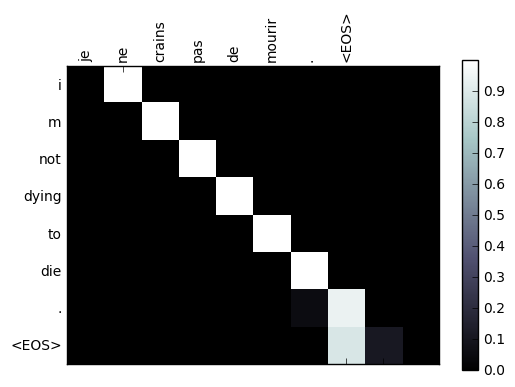

input =  c est un jeune directeur plein de talent .
output =  he is a talented young director . <EOS>


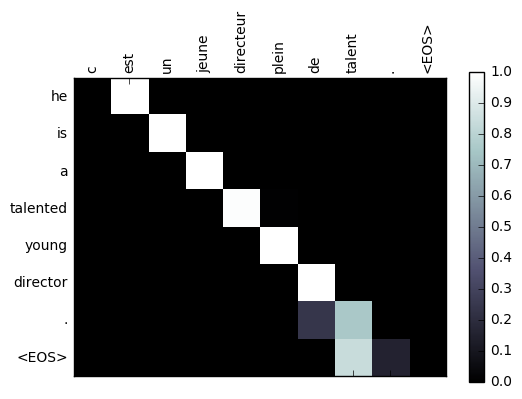

In [21]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with color bar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)
    
    # Set up axes
    ax.set_xticklabels(['']+input_sentence.split(' ')+['<EOS>'], rotation=90)
    ax.set_yticklabels(['']+output_words)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input = ', input_sentence)
    print('output = ', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")